In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [11]:
class PointCorresponder():
    def __init__(self):
        self.km = KMeans(n_clusters = 5, n_init = 10, random_state = 170)

        self.R = 25
        self.L = 0.25
        self.FOV = np.deg2rad(80)
        self.threshold = 0.1
        self.θ_tilde = np.arcsin(self.L/self.R * np.sin(self.FOV))

    def window_data(self, data:np.ndarray, window: np.ndarray) -> np.ndarray:
        x, y = data[:,0], data[:,1]
        bounds = [np.argwhere(np.isclose(x, w))[0][0] for w in window[0]]
        temp = np.array([x[bounds[0]:bounds[1]], y[bounds[0]:bounds[1]]]).T
        windowed= [row for row in temp if (window[1][0]<=row[1]<=window[1][1])]
        return np.array(windowed)

    def polar_cartesian_convert(self, polar:np.array) -> np.array:
        return np.array([polar[:,1]*np.cos(polar[:,0]), polar[:,1]*np.sin(polar[:,0])]).T
    
    def points_polar(self, θ_obs: float, scan: np.ndarray,  θ_err: float = np.pi/6) -> np.array:
        windowed = self.window_data(scan, np.array([[θ_obs[0]-θ_err, θ_obs[0]+θ_err],[0,self.R]]))
        kmeans = self.km.fit(windowed)
        obs = kmeans.cluster_centers_.tolist()
        for θ in θ_obs[1:]:
            windowed = self.window_data(scan, np.array([[θ-θ_err, θ+θ_err],[0,self.R]]))
            kmeans = self.km.fit(windowed)
            clusters = kmeans.cluster_centers_
            new_clusters = [[c] for c in clusters if np.any(np.abs(obs -c) >= self.threshold)]
            obs.extend(clusters)
        return np.array(obs)

In [12]:
point_corresponder = PointCorresponder()


In [13]:
scan = np.loadtxt("ranges.csv", delimiter=",")
window = point_corresponder.window_data(scan, np.array([[-np.pi/2, np.pi/2],[0,25]]))

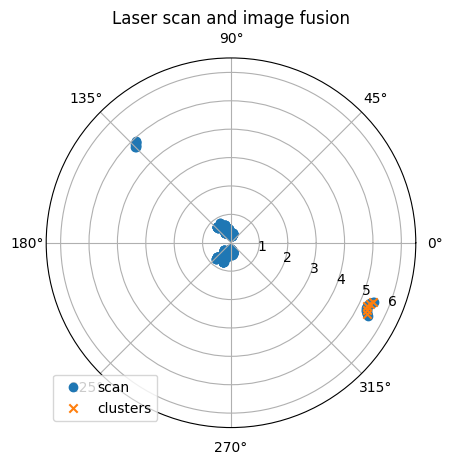

In [14]:
obs_polar = point_corresponder.points_polar(np.array([-np.pi/6]), scan)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(scan[:,0],scan[:,1],label="scan")
ax.scatter(obs_polar[:,0],obs_polar[:,1],marker="x",label="clusters")
ax.set_rmax(1.2*max(obs_polar[:,1]))
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_title("Laser scan and image fusion")
ax.grid(True)
plt.legend(loc=3)
plt.show()